### Meaning of each column:

**1) country:** The country that the wine is from.<br>
**2) description:** A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.<br>
**3) designation:** The vineyard within the winery where the grapes that made the wine are from.<br>
**4) points:** The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)<br>
**5) price:** The cost for a bottle of the wine. <br>
**6) province:** The province or state that the wine is from.<br>
**7) region_1:** The wine growing area in a province or state (ie Napa).<br>
**8) region_2:** Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.<br>
**9) variety:** The type of grapes used to make the wine (ie Pinot Noir). <br>
**10) winery:** The winery that made the wine. <br>


In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

**Load data + Train-test split:**

In [2]:
### Start from raw data:
# raw_data = utils.loadRawData()
# data = utils.cleanAndTransform(raw_data)
# utils.saveData(data)

### Start from processed data:
data = utils.loadCleanData('data/clean_v1.csv')

In [3]:
# I'm just gonna work with these columns:
M = data[['country', 'description', 'points', 'price', 'variety', 'clean_des']].values

# Train-test split:
X = M[:, -1]
Y = M[:, :-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## 1. Data visualization without "description": 

**I want to first look into how diverse the data are. Will there be some clusters in the feature space constructed by "country", "points", "price", "variety". I'm hoping to see the distribution of data points considering these four columns similar to that of the descriptions.**

1. country: one-hot-encoding
2. points: normalization
3. price: category
4. variety: one-hot-encoding

In [6]:
y_train = Y_train[:, [0,2,3,4]]
column_names = ['country', 'points', 'price', 'variety']

# COne-hot encode country:
for c in np.unique(y_train[:, 0]):
    y_train = np.append(y_train, np.reshape(np.array(y_train[:, 0]==c).astype(int), (-1, 1)), axis=1)
    column_names.append(c)
    
# Rescale points:
y_train = np.append(y_train, np.reshape(y_train[:, 1]/20, (-1, 1)), axis=1)
column_names.append('nor_points')

# Categorize price:
def categorize_price(value):
    if value < 22.0:
        return 1
    elif value < 33.0 and value >= 22.0:
        return 2
    elif value < 50.0 and value >= 33.0:
        return 3
    elif value < 80.0 and value >= 50.0:
        return 4
    else:
        return 5

vfunc = np.vectorize(categorize_price)
y_train = np.append(y_train, np.reshape(vfunc(y_train[:, 2]), (-1, 1)), axis=1)
column_names.append('cat_price')

In [5]:
# One-hot-encode variety:
for v in np.unique(y_train[:, 3]):
    y_train = np.append(y_train, np.reshape(np.array(y_train[:, 3]==v).astype(int), (-1, 1)), axis=1)
    column_names.append(v)

In [112]:
# # Drop the original four columns:
# y_train = y_train[:, 4:]
# column_names = column_names[4:]

In [7]:
pca = PCA(n_components=3)
pca_y_train = pca.fit_transform(y_train[:, 4:])

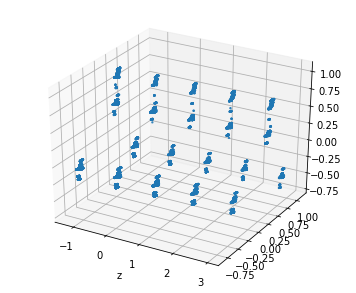

In [8]:
fig = plt.figure(figsize=[6, 5])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_y_train[:, 0], pca_y_train[:, 1], pca_y_train[:, 2], marker='o', s=2)
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')
plt.show()

Summary: It really looks like the data disperse base on their price category and country...

## 2. Look into "description":

### Goal: Find out the characters of different type of wine from the description.

### Step 1: Tokenization:

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create vectorizer:
# Only preserve words with freq=0.05~0.8
t_vec = TfidfVectorizer(max_df=0.8, min_df=0.05, max_features=20000, stop_words='english')

%time t_matrix = t_vec.fit_transform(X_train)

CPU times: user 2.34 s, sys: 71.3 ms, total: 2.42 s
Wall time: 2.42 s


In [5]:
words = t_vec.get_feature_names()
print('length=', len(words))
print(words)

length= 67
['acidity', 'apple', 'aromas', 'balanced', 'berry', 'bit', 'black', 'blackberry', 'blend', 'bodied', 'bright', 'cabernet', 'character', 'cherries', 'cherry', 'chocolate', 'citrus', 'clean', 'crisp', 'dark', 'drink', 'dry', 'fine', 'finish', 'firm', 'flavors', 'fresh', 'fruit', 'fruits', 'fruity', 'good', 'green', 'light', 'like', 'little', 'long', 'mouth', 'nose', 'notes', 'oak', 'offers', 'palate', 'peach', 'pepper', 'pinot', 'plum', 'raspberry', 'red', 'rich', 'ripe', 'sauvignon', 'shows', 'smooth', 'soft', 'spice', 'spicy', 'structure', 'style', 'sweet', 'tannic', 'tannins', 'texture', 'touch', 'vanilla', 'white', 'wine', 'years']


In [6]:
# Save words:
# pd.DataFrame(words, columns=['word']).to_csv('data/cluster_words_v1.csv')
words = pd.read_csv('data/cluster_words_v1.csv')['word'].values

### Step 2: Data visualization -- PCA

In [7]:
from scipy.sparse import csc_matrix

# Transform sparce matrix to dataframe
coo = t_matrix.tocoo(copy=False)
coo_df = pd.DataFrame({'index': coo.row, 'col': coo.col, 'data': coo.data}
                     )[['index', 'col', 'data']].sort_values(['index', 'col']).reset_index(drop=True)

In [8]:
# Vectorization:

inds = np.unique(coo_df['index'])
w_counts = len(words)
coo_matrix=[]
for i in inds:
    row = np.zeros(w_counts)
    sub_df = coo_df[coo_df['index']==i]
    for j in range(len(sub_df)):
        row[sub_df.col.iloc[j]] = sub_df.data.iloc[j]
    coo_matrix.append(row)
    
coo_matrix = np.array(coo_matrix)

In [59]:
t_df = pd.DataFrame(data=coo_matrix, columns=words)

# Save vectorized dataframe:
t_df.to_csv('data/word_matrix_v1.csv')
t_df = pd.read_csv('data/word_matrix_v1.csv')

In [63]:
t_df.head(5)

,acidity,apple,aromas,balanced,berry,bit,black,blackberry,blend,bodied,...,style,sweet,tannic,tannins,texture,touch,vanilla,white,wine,years
0,0.380528,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.383394,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.307086,0.0,0.272153,0.0,0.000000,0.0,0.0,0.180799,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.365854,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.271371,0.0,0.320868,0.0,...,0.0,0.000000,0.0,0.247391,0.0,0.365314,0.0,0.0,0.164350,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.372698,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


In [48]:
pca = PCA(n_components=3)
pca_t_matrix = pca.fit_transform(t_df.values)

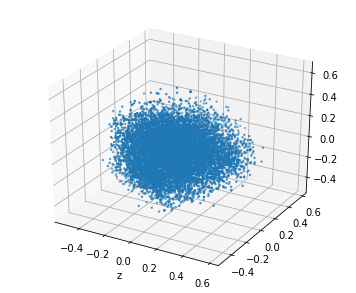

In [51]:
fig = plt.figure(figsize=[6, 5])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_t_matrix[::10, 0], pca_t_matrix[::10, 1], pca_t_matrix[::10, 2], marker='o', s=2)
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')
plt.show()

### Step 3: K-means clustering:

In [14]:
from sklearn.cluster import KMeans
n_clusters = 5

In [15]:
km = KMeans(n_clusters=n_clusters)

%time km.fit(t_matrix)
clusters = km.labels_.tolist()

CPU times: user 3min 55s, sys: 1.13 s, total: 3min 56s
Wall time: 3min 50s


In [16]:
from sklearn.externals import joblib

# joblib.dump(km,'data/cluster2_v1.pkl')
km = joblib.load('data/cluster2_v1.pkl')

In [17]:
clusters = km.labels_.tolist()

### Step 4: Include cluster in data:

In [18]:
reviews = {'country':Y_train[:, 0], 'points':Y_train[:, 2].astype(int), 'price':Y_train[:, 3].astype(float), 
          'variety':Y_train[:, -1], 'description':Y_train[:, 1], 'clean_des':X_train, 'cluster':clusters}

df = pd.DataFrame(reviews, columns = ['country', 'points', 'price', 'variety', 'description', 'clean_des', 'cluster'])

In [19]:
df.head(5)

,country,points,price,variety,description,clean_des,cluster
0,Other,7,17.0,Cabernet Sauvignon,Boasts tremendously ripe fruit—the stated alco...,boasts tremendously ripe fruit stated alcohol ...,2
1,US,7,34.0,Cabernet Franc,"Ripe and smooth, with polished cherry pie fill...",ripe smooth polished cherry pie filling red cu...,0
2,France,10,25.0,Rosé,"This is a stylish wine, fruity with red curran...",stylish wine fruity red currants herbs delicio...,2
3,Italy,13,85.0,Red Blend,This vintage has some Cabernet Sauvignon and P...,vintage cabernet sauvignon petit verdot blend ...,4
4,US,9,17.0,Merlot,"Aromatic and fruity, this is front-loaded with...",aromatic fruity front loaded pretty accents to...,4


In [20]:
# Save dataframe:
# df.to_csv('data/cluster_df_v1.csv', encoding='utf-8', index=False)
df = pd.read_csv('data/cluster_df_v1.csv')

**Number of data points in each cluster:**

In [21]:
cluster_counts = df['cluster'].value_counts()
cluster_counts

1    27031
0    25312
2    22479
3    20587
4     7513
Name: cluster, dtype: int64

**Mean of points for each cluster:**

In [22]:
df['points'].groupby(df['cluster']).mean()

cluster
0    7.248933
1    7.688580
2    8.655278
3    7.189051
4    9.067350
Name: points, dtype: float64

**Mean of price for each cluster:**

In [23]:
df['price'].groupby(df['cluster']).mean()

cluster
0    33.129938
1    32.109208
2    40.037858
3    23.089523
4    43.984560
Name: price, dtype: float64

In [24]:
from __future__ import print_function

print("Top words for each cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(n_clusters):
    print("Cluster {} words: ".format(i), end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(words[ind], end=', ')
    print() #add whitespace
    print() #add whitespace
    
print()

Top words for each cluster:

Cluster 0 words: flavors, dry, sweet, cherry, oak, wine, pinot, cherries, rich, drink, 

Cluster 1 words: aromas, palate, finish, fruit, cherry, berry, black, flavors, plum, nose, 

Cluster 2 words: wine, fruit, acidity, tannins, ripe, fruits, rich, flavors, years, red, 

Cluster 3 words: citrus, apple, peach, white, flavors, fresh, crisp, wine, green, finish, 

Cluster 4 words: cabernet, sauvignon, blend, tannins, wine, black, flavors, fruit, blackberry, cherry, 




**Some characters per cluster:**

Cluster 0: may has stronger flavor, rich, dry, may has smell of oak, cherry.

Cluster 1: may has stronger aromas (words: aromas, nose, finish)

Cluster 2: may taste acidity, tannins (contribute astringency and bitterness), ripe

Cluster 3: white wine, has a fresh taste (made with fruits including apple, citrus, peach)

Cluster 4: made with cabernet sauvignon (a kind of grape), has darker color (may made with balckberry, cherry)

Let's take a look if this makes sense:

In [17]:
def print_samples(cluster, n=4):
    print('Cluster {}:'.format(cluster))
    print()
    for i in range(n):
        print('Sample {}: {}'.format(i+1, df[df['cluster']==cluster].iloc[np.random.randint(cluster_counts.loc[cluster]), 4]))
        print()

In [18]:
print_samples(0, 3)

Cluster 0:

Sample 1: Dry Creek has made yet another delicious Chenin Blanc at a screaming fair price. Pleasantly and conservatively sweet in smell and taste, it shows nice melon and pineapple flavors, with a fresh, creamy texture. Fermented in stainless steel, the wine has 0.6% residual sugar.

Sample 2: This is one of the richer, finer wines out of Napa meant for drinking now. With smooth tannins and a soft mouthfeel, it shows sweet-tasting cherry jam, cassis and toasty oak flavors. This Bordeaux-style blend is based on Merlot.

Sample 3: An impressive Pinot. Shows massive fruity ripeness in a well-developed tannin structure, with good acidity, but it's really too young to drink now. Shows massive, primary flavors of black and red cherry pie filling, red plums and cola, with sweet, smoky, vanilla-infused oak influences. Hold until sometime in 2011.



In [19]:
print_samples(1, 3)

Cluster 1:

Sample 1: Deep and dark as night, with a lake's worth of cassis and black fruit aromas. There is no interference here; just pure, big-boned, modern-style Tempranillo flavors of currants, blackberry and soft, cuddly oak. Finishes with cream and coconut, but length and power as well. Hold until late 2010 and drink through 2015.

Sample 2: This is a fairly big, muscular Pinot Noir, with beefy black-cherry fruit and oaky overtones of brown sugar. Give it a year or more to smooth out, because the long, intense finish filled with berry fruit shows tremendous promise. Drink 2013–2020.

Sample 3: Mancini has 20% Carignane field-blended within, and shows burly, thick black fruit at its core. Integrated oak supports black cherry and pepper. A dustiness on the palate that finishes ripe.



In [20]:
print_samples(2, 3)

Cluster 2:

Sample 1: This is well-balanced and ripe, with plenty of room for both the attractive black fruits and the firm tannic structure. Wood aging shows, although it will integrate well. The wine is fruity, likely to be ready to drink from 2016.

Sample 2: From a field blend of old vines, this is a beautifully ripe, rounded, wood-aged wine that still preserves an internal structure. With its stone-fruit and mineral character, it is both fruity and textured. It's a wine for aging over 4–5 years.

Sample 3: Oak completely overwhelms this wine. All you can smell and taste is char, caramel and wood spice, and the tannins, which are partly from oak barrels, are dense and hard. It's difficult even to discern any underlying fruit flavors, although if you try hard, you stumble across blackberries.



In [21]:
print_samples(3, 3)

Cluster 3:

Sample 1: This Albariño is a pretty little wine and refreshingly different. There's subtle white flowers and quince upfront, followed by a light-bodied but intensely perfumed palate. While the mouth is a bit soft, this wine ends with a refreshing kick of acid. Try with light fish dishes.

Sample 2: This plump, medium-bodied kabinett features scents of pineapple, ginger, cinnamon and slate, while the bold flavors of citrus and spice are tempered by minerality and a touch of pithiness.

Sample 3: Aromas of Spanish broom, tropical fruit and graphite take the lead. The smooth, creamy palate offers white peach, melon, almond and mineral brightened by crisp acidity. Enjoy now through 2016.



### Step 5: Visualize clustered data

In [67]:
reduced_data = PCA(n_components=2).fit_transform(t_df.values)

In [68]:
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [69]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(reduced_data)

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

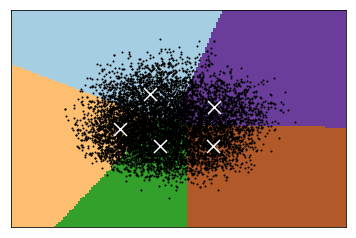

In [70]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect='auto', origin='lower')

plt.plot(reduced_data[::12, 0], reduced_data[::12, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
plt.xlim(x_min+0.8, x_max-0.8)
plt.ylim(y_min+0.8, y_max-0.8)
plt.xticks(())
plt.yticks(())
plt.show()